In [7]:
'''
Beginning implementation of "Motion without movement" illusions
(Debugging and playing with other filters)
'''

import cv2
from PIL import Image
import matplotlib.pylab as plt
import os
import numpy as np 
import imageio
from skimage.exposure import rescale_intensity
from math import exp, cos, sin
from scipy.ndimage import gaussian_filter, laplace, gaussian_laplace, sobel
from tqdm import tqdm 
from pathlib import Path
from scipy.signal import hilbert, convolve
import math
import shutil 


In [2]:
def make_gif(img_paths, gif_path, fps):
    # from: https://github.com/tuananhle7/continuous_mws/blob/master/cmws/util.py 
    Path(gif_path).parent.mkdir(parents=True, exist_ok=True)
    images = []
    for img_path in tqdm(img_paths):
        images.append(imageio.imread(img_path))
    imageio.mimsave(gif_path, images, duration=1 / fps)

def second_deriv_gauss(x,y,theta=0): 
    # G_2^theta = k_a(theta)*G_2a + k_b(theta)*G_2b + k_c(theta)*G_2c
    # values from Table 1 (p. 29)
    
    G_2a = 0.9123 * (2*(x**2) - 1)*exp(-(x**2 + y**2))
    G_2b = 1.843 * x * y * exp(-(x**2 + y**2))
    G_2c = 0.9123*(2*(y**2) - 1)*exp(-(x**2 + y**2))
    
    k_a = cos(theta) ** 2 
    k_b = -2*cos(theta) * sin(theta)
    k_c = sin(theta)**2
    
    return k_a * G_2a + k_b * G_2b + k_c * G_2c   

def custom_hilbert(x,y,theta=0): 
    # values from Table 3 (p. 30)
    
    H_2a = 0.9780*(-2.254*x + x**3)*exp(-(x**2 + y**2))
    H_2b = 0.9780*(-0.7515 + x**2)*exp(-(x**2 + y**2))
    H_2c = 0.9780*(-0.7515 + y**2)*exp(-(x**2 + y**2))
    H_2d = 0.9780*(-2.254*y + y**3)*exp(-(x**2 + y**2))
    
    k_a = cos(theta) ** 3 
    k_b = -3*(cos(theta)**2)*sin(theta)
    k_c  = 3*(sin(theta)**2)*cos(theta)
    k_d = -sin(theta) ** 3 
    
    return k_a * H_2a + k_b * H_2b + k_c * H_2c + k_d * H_2d
    

Img Shape: (392, 504)


(-0.5, 503.5, 391.5, -0.5)

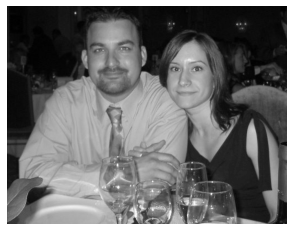

In [3]:
# load in image to be transformed and convert to grayscale
# help from: https://stackoverflow.com/questions/60050816/converting-rgb-to-grayscale-python

img_pth = "./couple.jpg"

# convert to grayscale 
img = Image.open(img_pth).convert('LA') 
img = np.asarray(img)[:,:,0]

print(f"Img Shape: {np.shape(img)}")

cmap='gray'
plt.imshow(img, cmap=cmap)
plt.axis('off')

(-0.5, 503.5, 391.5, -0.5)

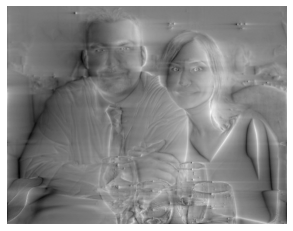

In [4]:
transf_img =  np.imag(hilbert(img)) # help from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

plt.imshow(transf_img, cmap=cmap)
plt.axis('off')

(-0.5, 503.5, 391.5, -0.5)

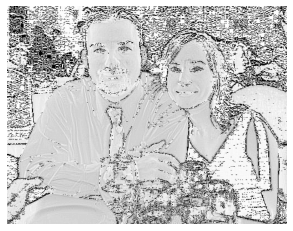

In [22]:
sigma=0.57
transf_img =  gaussian_laplace(img, sigma=sigma) # help from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

plt.imshow(transf_img, cmap=cmap)
plt.axis('off')

(-0.5, 503.5, 391.5, -0.5)

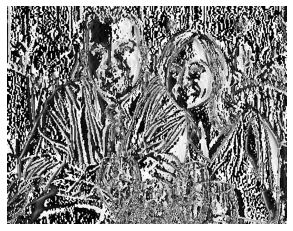

In [11]:
plt.imshow(sobel(img,axis=-1), cmap="gray")
plt.axis('off')

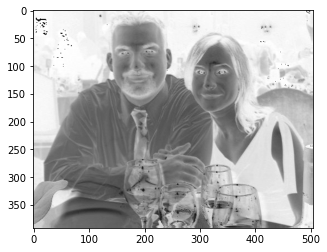

In [20]:
from scipy.ndimage import filters
transf_img = filters.convolve(img, kernel)
plt.imshow(transf_img, cmap="gray")

In [6]:
def create_filter(filter_func, filter_size, theta): 
    # filter_func is a function that takes as input x,y,theta
    sample_filter = []
    for x in range(filter_size):
        filt_vals = []
        for y in range(filter_size):
            filt_val = filter_func(x,y,theta)
            filt_vals.append(filt_val)
        sample_filter.append(filt_vals)
    sample_filter = np.array(sample_filter) 
    return sample_filter 

size = 5#img.shape[0]
theta = 0.56#0.5
omega = 0.5
t = 1

# eq 3: 
E = convolve(img, create_filter(second_deriv_gauss, size, theta), mode="same")

# eq 4: 
O = convolve(img, create_filter(custom_hilbert, size, theta), mode = "same")

# eq 5:
D = cos(omega*t)*E + sin(omega*t)*O

In [21]:
kernel = create_filter(second_deriv_gauss, size, theta)
kernel

array([[-9.12300000e-01, -1.46222180e-01,  2.10081773e-02,
         4.59225422e-04,  8.24312330e-07],
       [ 1.46222180e-01, -1.01039308e-01, -5.80130173e-03,
         2.46339516e-06,  8.27641074e-08],
       [ 7.92479668e-02,  1.02676142e-02, -8.36779521e-05,
        -2.24467927e-06, -1.45735530e-09],
       [ 1.34216281e-03,  2.91187405e-04,  6.73952200e-06,
         8.82019857e-09, -1.10233200e-11],
       [ 2.25566287e-06,  5.76418266e-07,  1.82047194e-08,
         6.62578565e-11,  2.20247336e-14]])

(-0.5, 4.5, 4.5, -0.5)

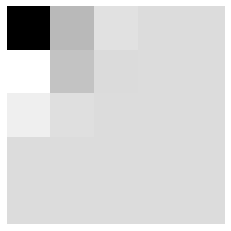

In [12]:
plt.imshow(create_filter(second_deriv_gauss, size, theta), cmap="gray")
plt.axis('off')

(-0.5, 4.5, 4.5, -0.5)

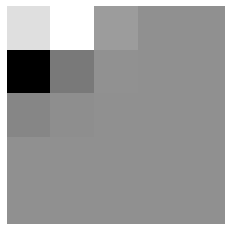

In [13]:
plt.imshow(create_filter(custom_hilbert, size, theta), cmap="gray")
plt.axis('off')